In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# ignore warnings   
import warnings
warnings.filterwarnings('ignore')

# Define color palette for plots (if needed)
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
palette_cmap = 'Blues'  # For the heatmap


In [37]:
import os
print(os.getcwd())

D:\Programs\ML_mypractice


In [38]:
# 1. 加载数据
df_train = pd.read_csv("./CSV/Churn_Modelling.csv")  
df_train.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [39]:
pd.set_option('display.max_columns', None) 

In [40]:
df_train.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [41]:
num_train_rows, num_train_columns = df_train.shape
print("Training Data:")
print(f"Number of Rows: {num_train_rows}")
print(f"Number of Columns: {num_train_columns}\n")

Training Data:
Number of Rows: 10000
Number of Columns: 14



In [42]:
train_null = df_train.isnull().sum().sum()
print(f'Null Count in Train: {train_null}')

Null Count in Train: 0


In [43]:
train_duplicates = df_train.duplicated().sum()
print(f"Number of duplicate rows in train_data: {train_duplicates}")

Number of duplicate rows in train_data: 0


In [44]:
num_train_rows, num_train_columns = df_train.shape

print("Training Data:")
print(f"Number of Rows: {num_train_rows}")
print(f"Number of Columns: {num_train_columns}\n")

Training Data:
Number of Rows: 10000
Number of Columns: 14



In [45]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [46]:
df_train.describe()

RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000      5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
min         0.000000       1.000000      0.00000        0.000000   
25%         0.000000       1.000000      0.00000        0.000000   
50%     97198.540000       1.000000      1.00000        1.000000   
75%    127644.240000       2.000000      1.00000        1.000000   
max    250898.090000       4.000000      1.00000        1.000000   

       EstimatedSalary        Exited  
count     10000.000000  10000.000000  
mean     100090.239881      0.203700  
std       57510.492818      0.402769  
min          11.580000      0.000000  
25%       51002.110000      0.000000  
50%      100193.915000      0.000000  
75%      149388.247500      0.000000  
max      199992.480000      1.000000

In [47]:
train_null = df_train.isnull().sum().sum()
print(f'Null Count in Train: {train_null}')

Null Count in Train: 0


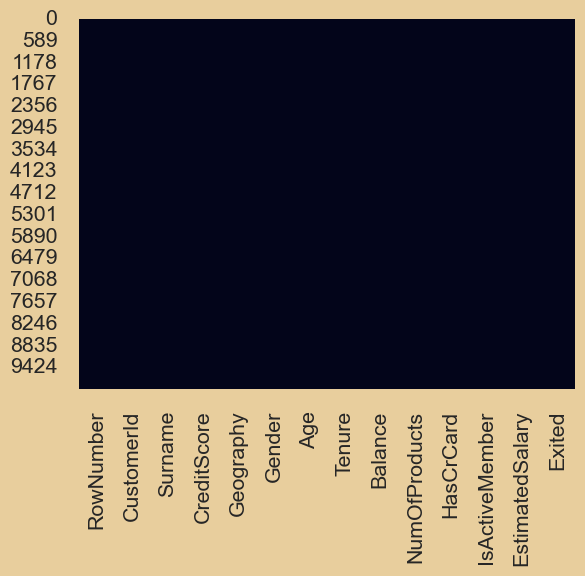

In [48]:
sns.heatmap(df_train.isnull(), cbar=False)
plt.show()

In [49]:
sns.set_style("white")
sns.set(rc={"axes.facecolor":"#E8CE9D","figure.facecolor":"#E8CE9D","grid.color":"white"})
sns.set_context("poster",font_scale = .7)

# palette = ["#432C0A","#f7941d","#6c9a76","#f25a29","#cc4b57"]
palette = ["#764a23","#f7941d","#6c9a76","#f25a29","#cc4b57"]
palette_cmap = ["#6c9a76","#cc4b57","#764a23","#f25a29","#f7941d"]

# sns.palplot(sns.color_palette(palette))
# sns.palplot(sns.color_palette(palette_cmap))
# plt.show()

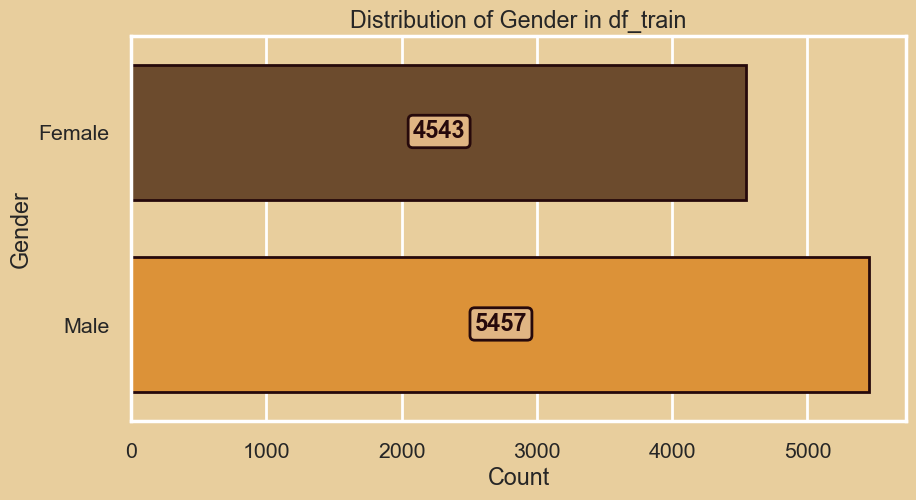

In [73]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="Gender", data=df_train, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color='#26090b', fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of Gender in df_train")
plt.xlabel("Count")
plt.ylabel("Gender")

plt.show()

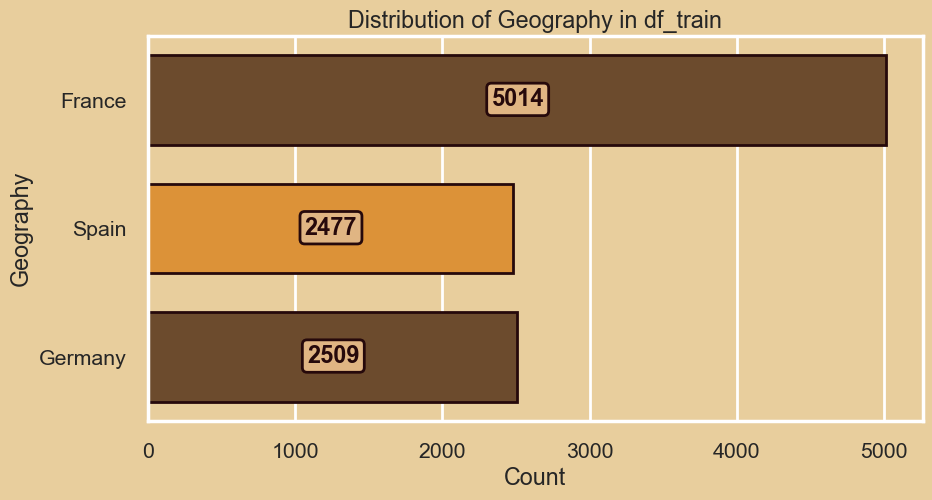

In [71]:
fig = plt.figure(figsize=(10, 5))


p = sns.countplot(y="Geography", data=df_train, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color='#26090b', fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of Geography in df_train")
plt.xlabel("Count")
plt.ylabel("Geography")

plt.show()

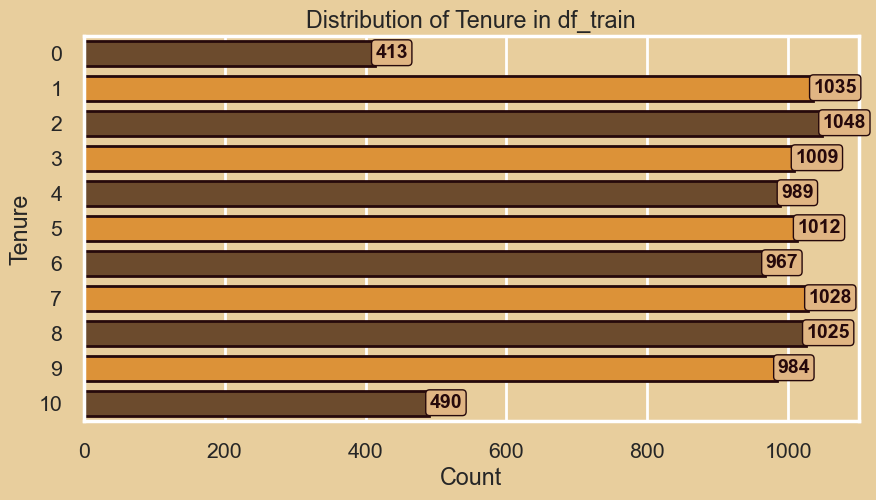

In [74]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="Tenure", data=df_train, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="edge", color='#26090b', fontsize=14, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 1, "alpha": 1})

plt.title("Distribution of Tenure in df_train")
plt.xlabel("Count")
plt.ylabel("Tenure")

plt.show()

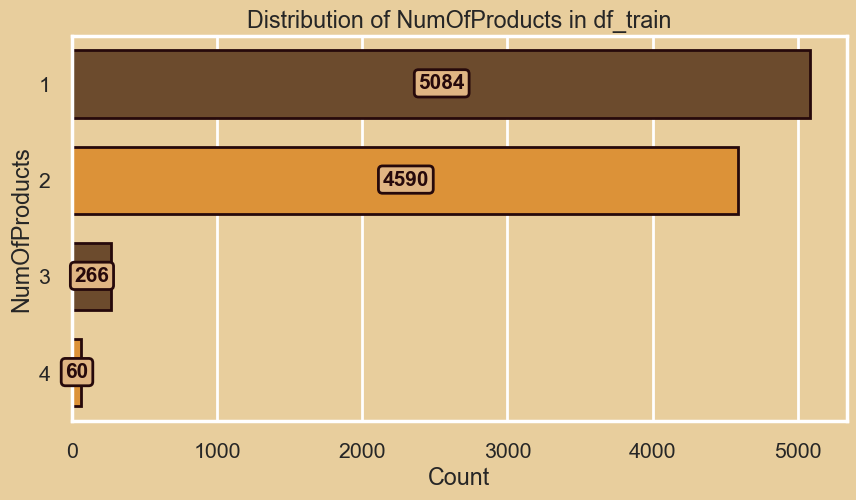

In [53]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="NumOfProducts", data=df_train, palette=palette[0:2]
                  , edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color='#26090b', fontsize=15, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of NumOfProducts in df_train")
plt.xlabel("Count")
plt.ylabel("NumOfProducts")

plt.show()

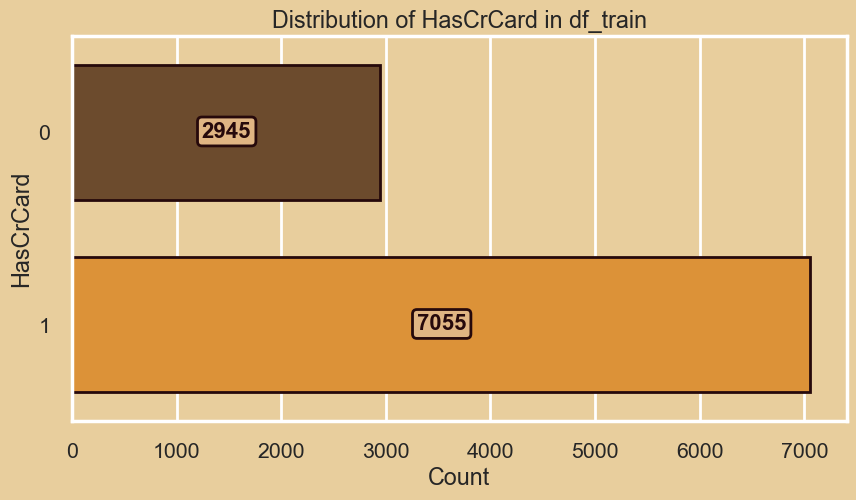

In [54]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="HasCrCard", data=df_train, palette=palette[0:2]
                  , edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color="#26090b", fontsize=16, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of HasCrCard in df_train")
plt.xlabel("Count")
plt.ylabel("HasCrCard")

plt.show()

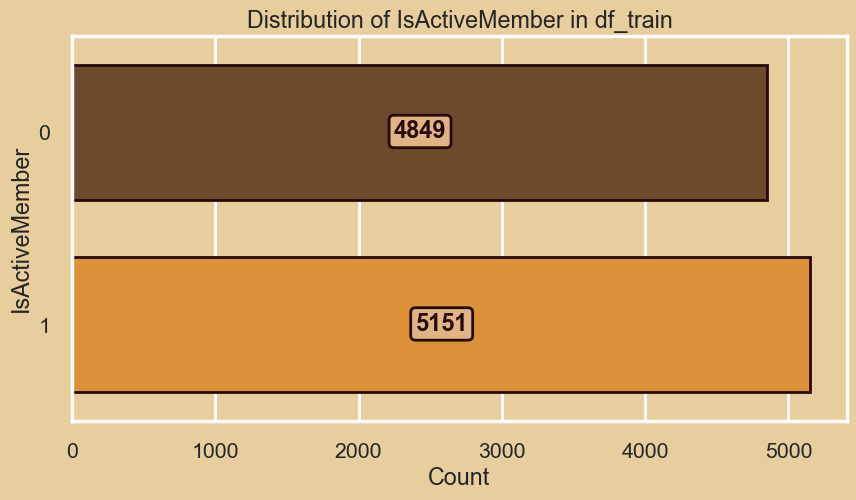

In [55]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="IsActiveMember", data=df_train, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color="#26090b", fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of IsActiveMember in df_train")
plt.xlabel("Count")
plt.ylabel("IsActiveMember")

plt.show()

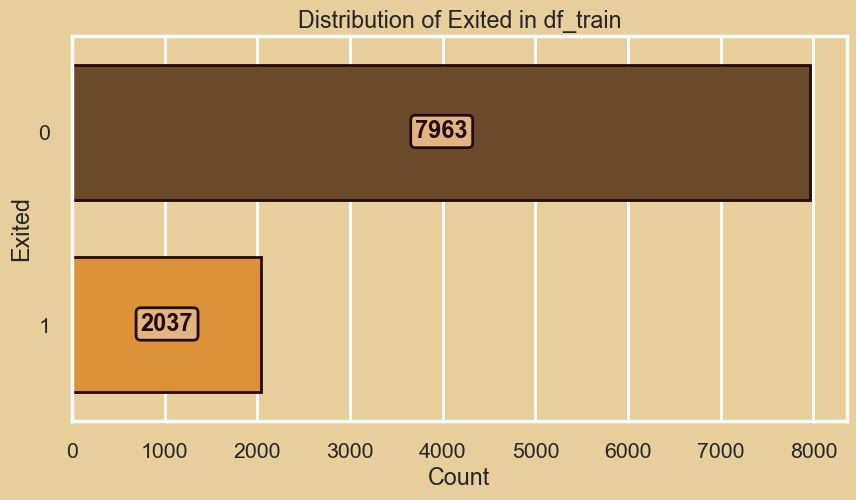

In [56]:
fig = plt.figure(figsize=(10, 5))


p = sns.countplot(y="Exited", data=df_train, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color="#26090b", fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of Exited in df_train")
plt.xlabel("Count")
plt.ylabel("Exited")

plt.show()

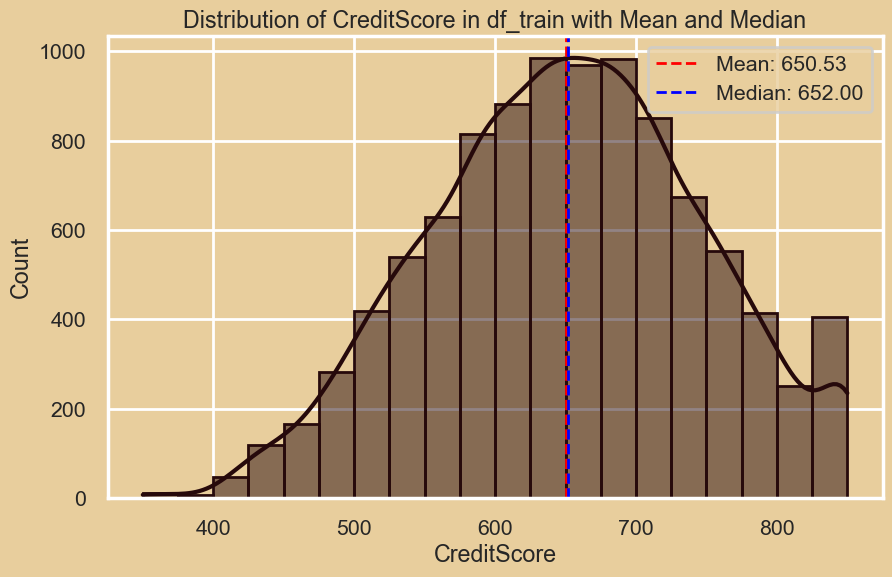

In [57]:
fig = plt.figure(figsize=(10, 6))

histplot = sns.histplot(data=df_train, x="CreditScore", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

histplot.get_lines()[0].set_color('#26090b')

mean_value = df_train["CreditScore"].mean()
median_value = df_train["CreditScore"].median()

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

plt.title("Distribution of CreditScore in df_train with Mean and Median")
plt.xlabel("CreditScore")
plt.ylabel("Count")

plt.legend()

plt.show()

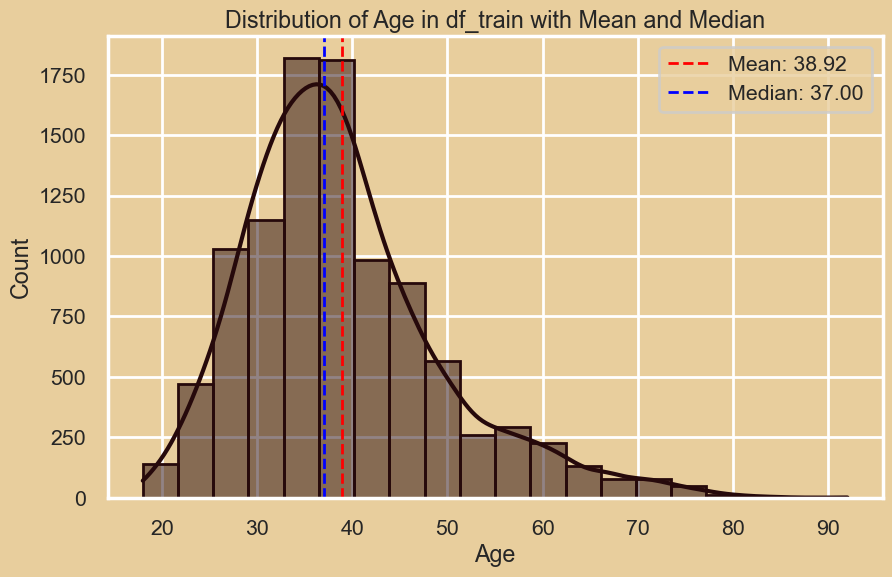

In [58]:
fig = plt.figure(figsize=(10, 6))

histplot = sns.histplot(data=df_train, x="Age", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

histplot.get_lines()[0].set_color('#26090b')

mean_value = df_train["Age"].mean()
median_value = df_train["Age"].median()

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

plt.title("Distribution of Age in df_train with Mean and Median")
plt.xlabel("Age")
plt.ylabel("Count")

plt.legend()

plt.show()

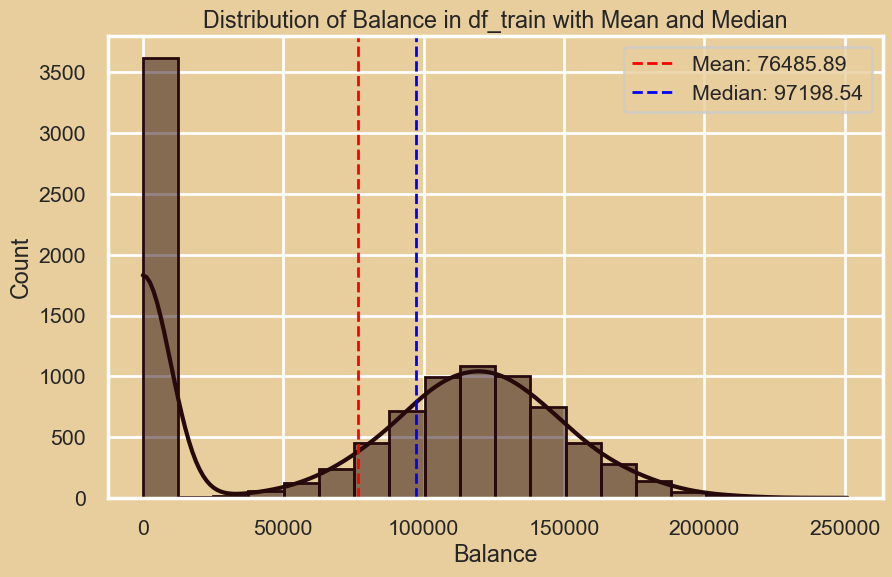

In [59]:
fig= plt.figure(figsize=(10, 6))


histplot = sns.histplot(data=df_train, x="Balance", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

histplot.get_lines()[0].set_color('#26090b')

mean_value = df_train["Balance"].mean()
median_value = df_train["Balance"].median()

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

plt.title("Distribution of Balance in df_train with Mean and Median")
plt.xlabel("Balance")
plt.ylabel("Count")

# Show legend
plt.legend()

plt.show()

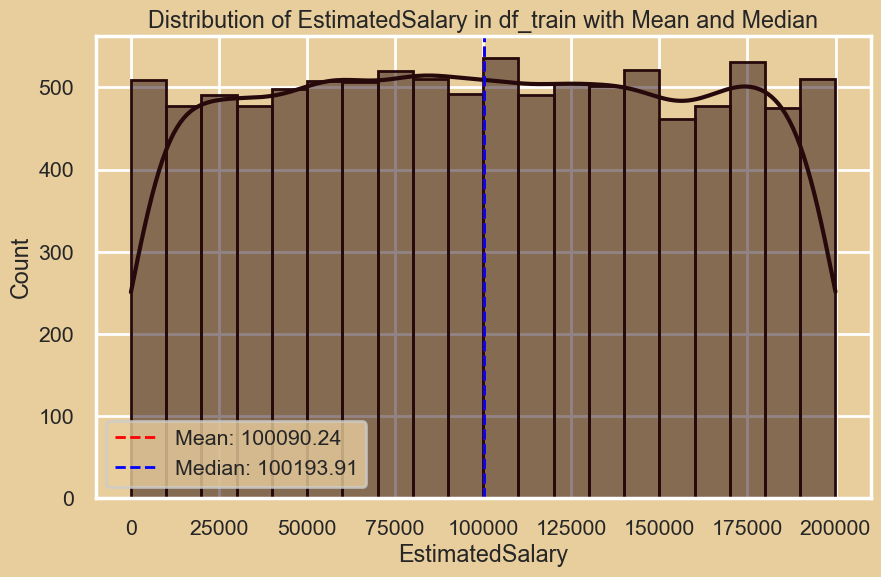

In [60]:
fig = plt.figure(figsize=(10, 6))

histplot = sns.histplot(data=df_train, x="EstimatedSalary", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

histplot.get_lines()[0].set_color('#26090b')

mean_value = df_train["EstimatedSalary"].mean()
median_value = df_train["EstimatedSalary"].median()

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

plt.title("Distribution of EstimatedSalary in df_train with Mean and Median")
plt.xlabel("EstimatedSalary")
plt.ylabel("Count")

plt.legend()

plt.show()

In [61]:
cat_cols = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember']

num_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

target = 'Exited'

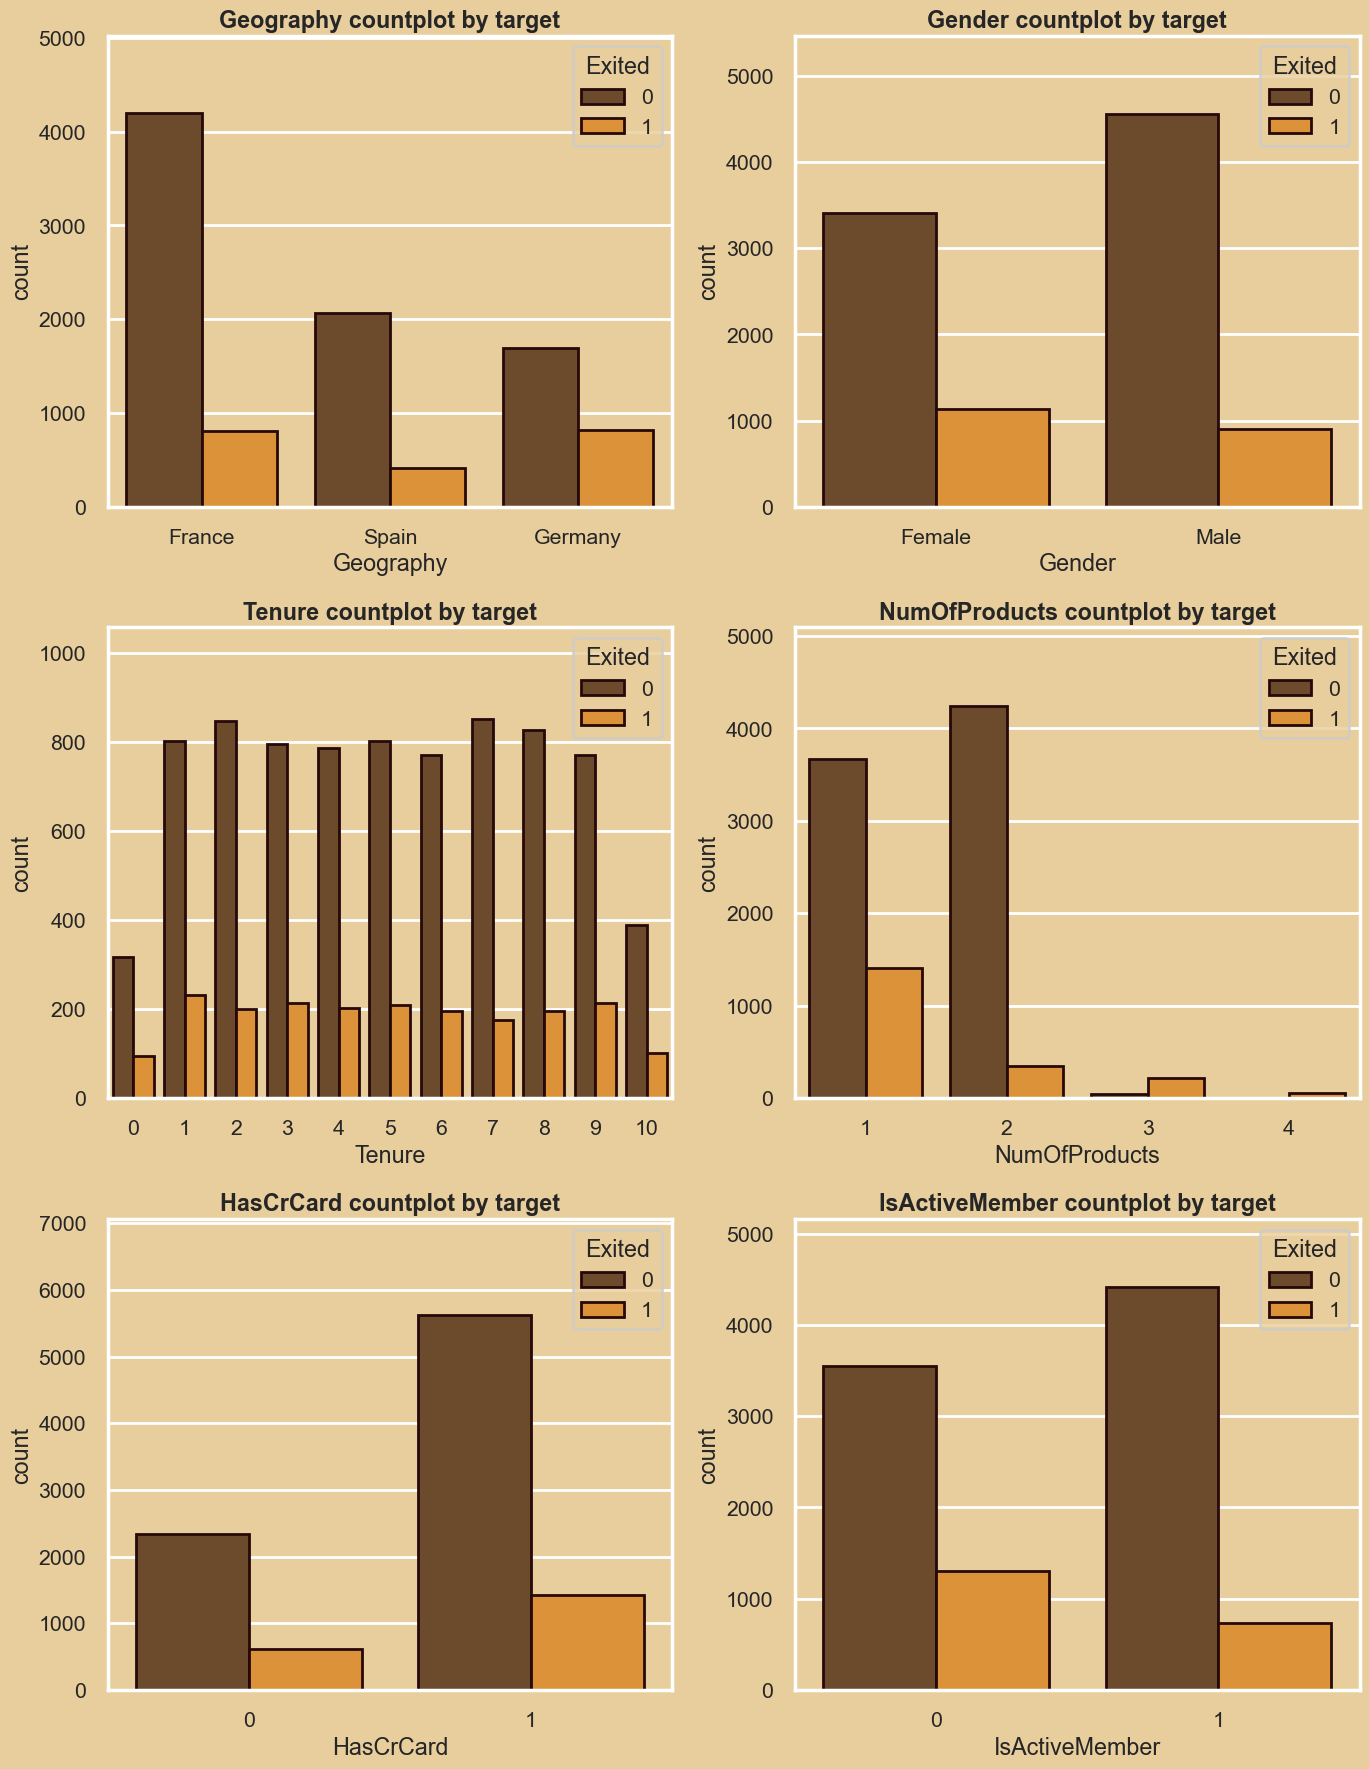

In [62]:
fig = plt.figure(figsize=(14, len(cat_cols)*3))

# background_color = 'grey'
for i, col in enumerate(cat_cols):
    
    plt.subplot(len(cat_cols)//2 + len(cat_cols) % 2, 2, i+1)
    sns.countplot(x=col, hue=target, data=df_train, palette=palette[0:2], color='#26090b', edgecolor='#26090b')
    plt.title(f"{col} countplot by target", fontweight = 'bold')
    plt.ylim(0, df_train[col].value_counts().max() + 10)
    
plt.tight_layout()
plt.show()

In [63]:
num_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

# Create subplots with two rows and two columns
fig = make_subplots(rows=2, cols=2)

# Background color
fig.update_layout(
    plot_bgcolor="#764a23",  # Set background color for the entire plot area
    paper_bgcolor="#E8CE9D",  # Set background color for the outer area
)

# Loop through numerical columns and add boxplots with color
for i, col in enumerate(num_cols, start=1):
    row_num = 1 if i <= 2 else 2
    col_num = i if i <= 2 else i - 2
    fig.add_trace(
        go.Box(
            x=df_train[col],
            name=col,
            marker_color='#26090b',  # Set box color
            line_color='#26090b'  # Set mean line color
        ),
        row=row_num,
        col=col_num
    )

# Update layout
fig.update_layout(
    title_text="Boxplots of Numerical Columns",
    showlegend=False
)

fig.show()

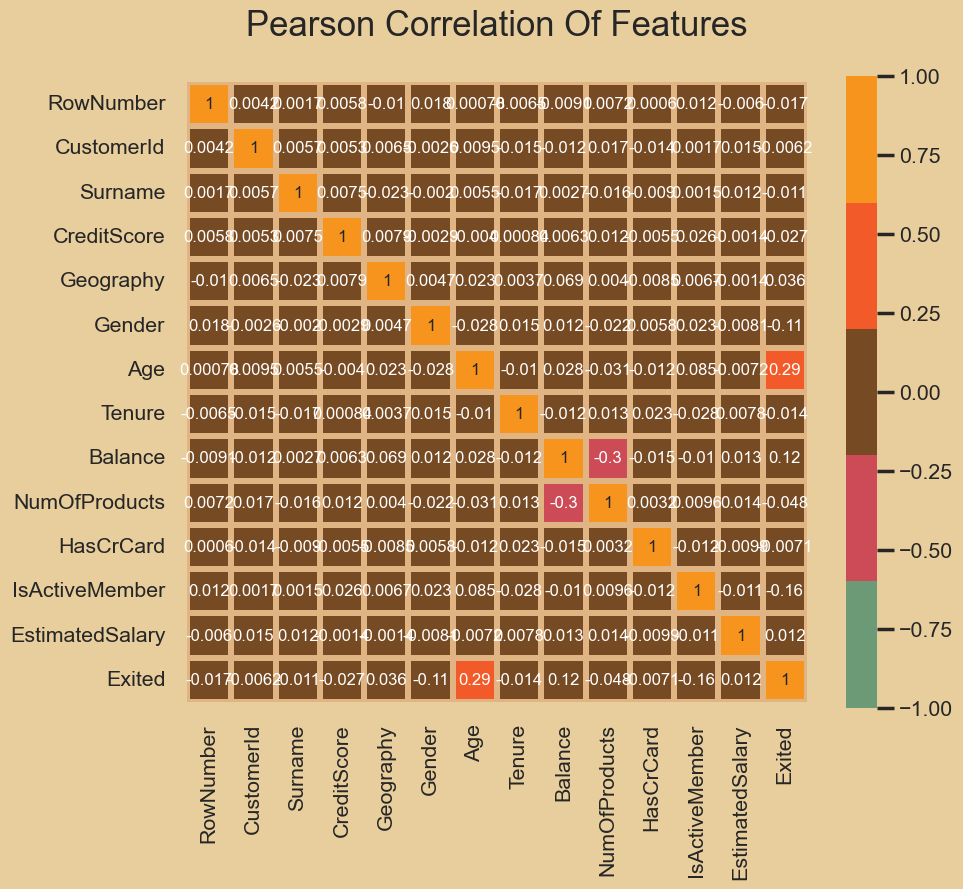

In [66]:
df_corr = df_train.copy()

catcol = [col for col in df_corr.columns if df_corr[col].dtype == "object"]
le = LabelEncoder()
for col in catcol:
        df_corr[col] = le.fit_transform(df_corr[col])


plt.subplots(figsize =(10, 10))

sns.heatmap(df_corr.corr(), cmap = palette_cmap, square=True, cbar_kws=dict(shrink =.82), 
            annot=True, vmin=-1, vmax=1, linewidths=3,linecolor='#e0b583',annot_kws=dict(fontsize =12))
plt.title("Pearson Correlation Of Features\n", fontsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

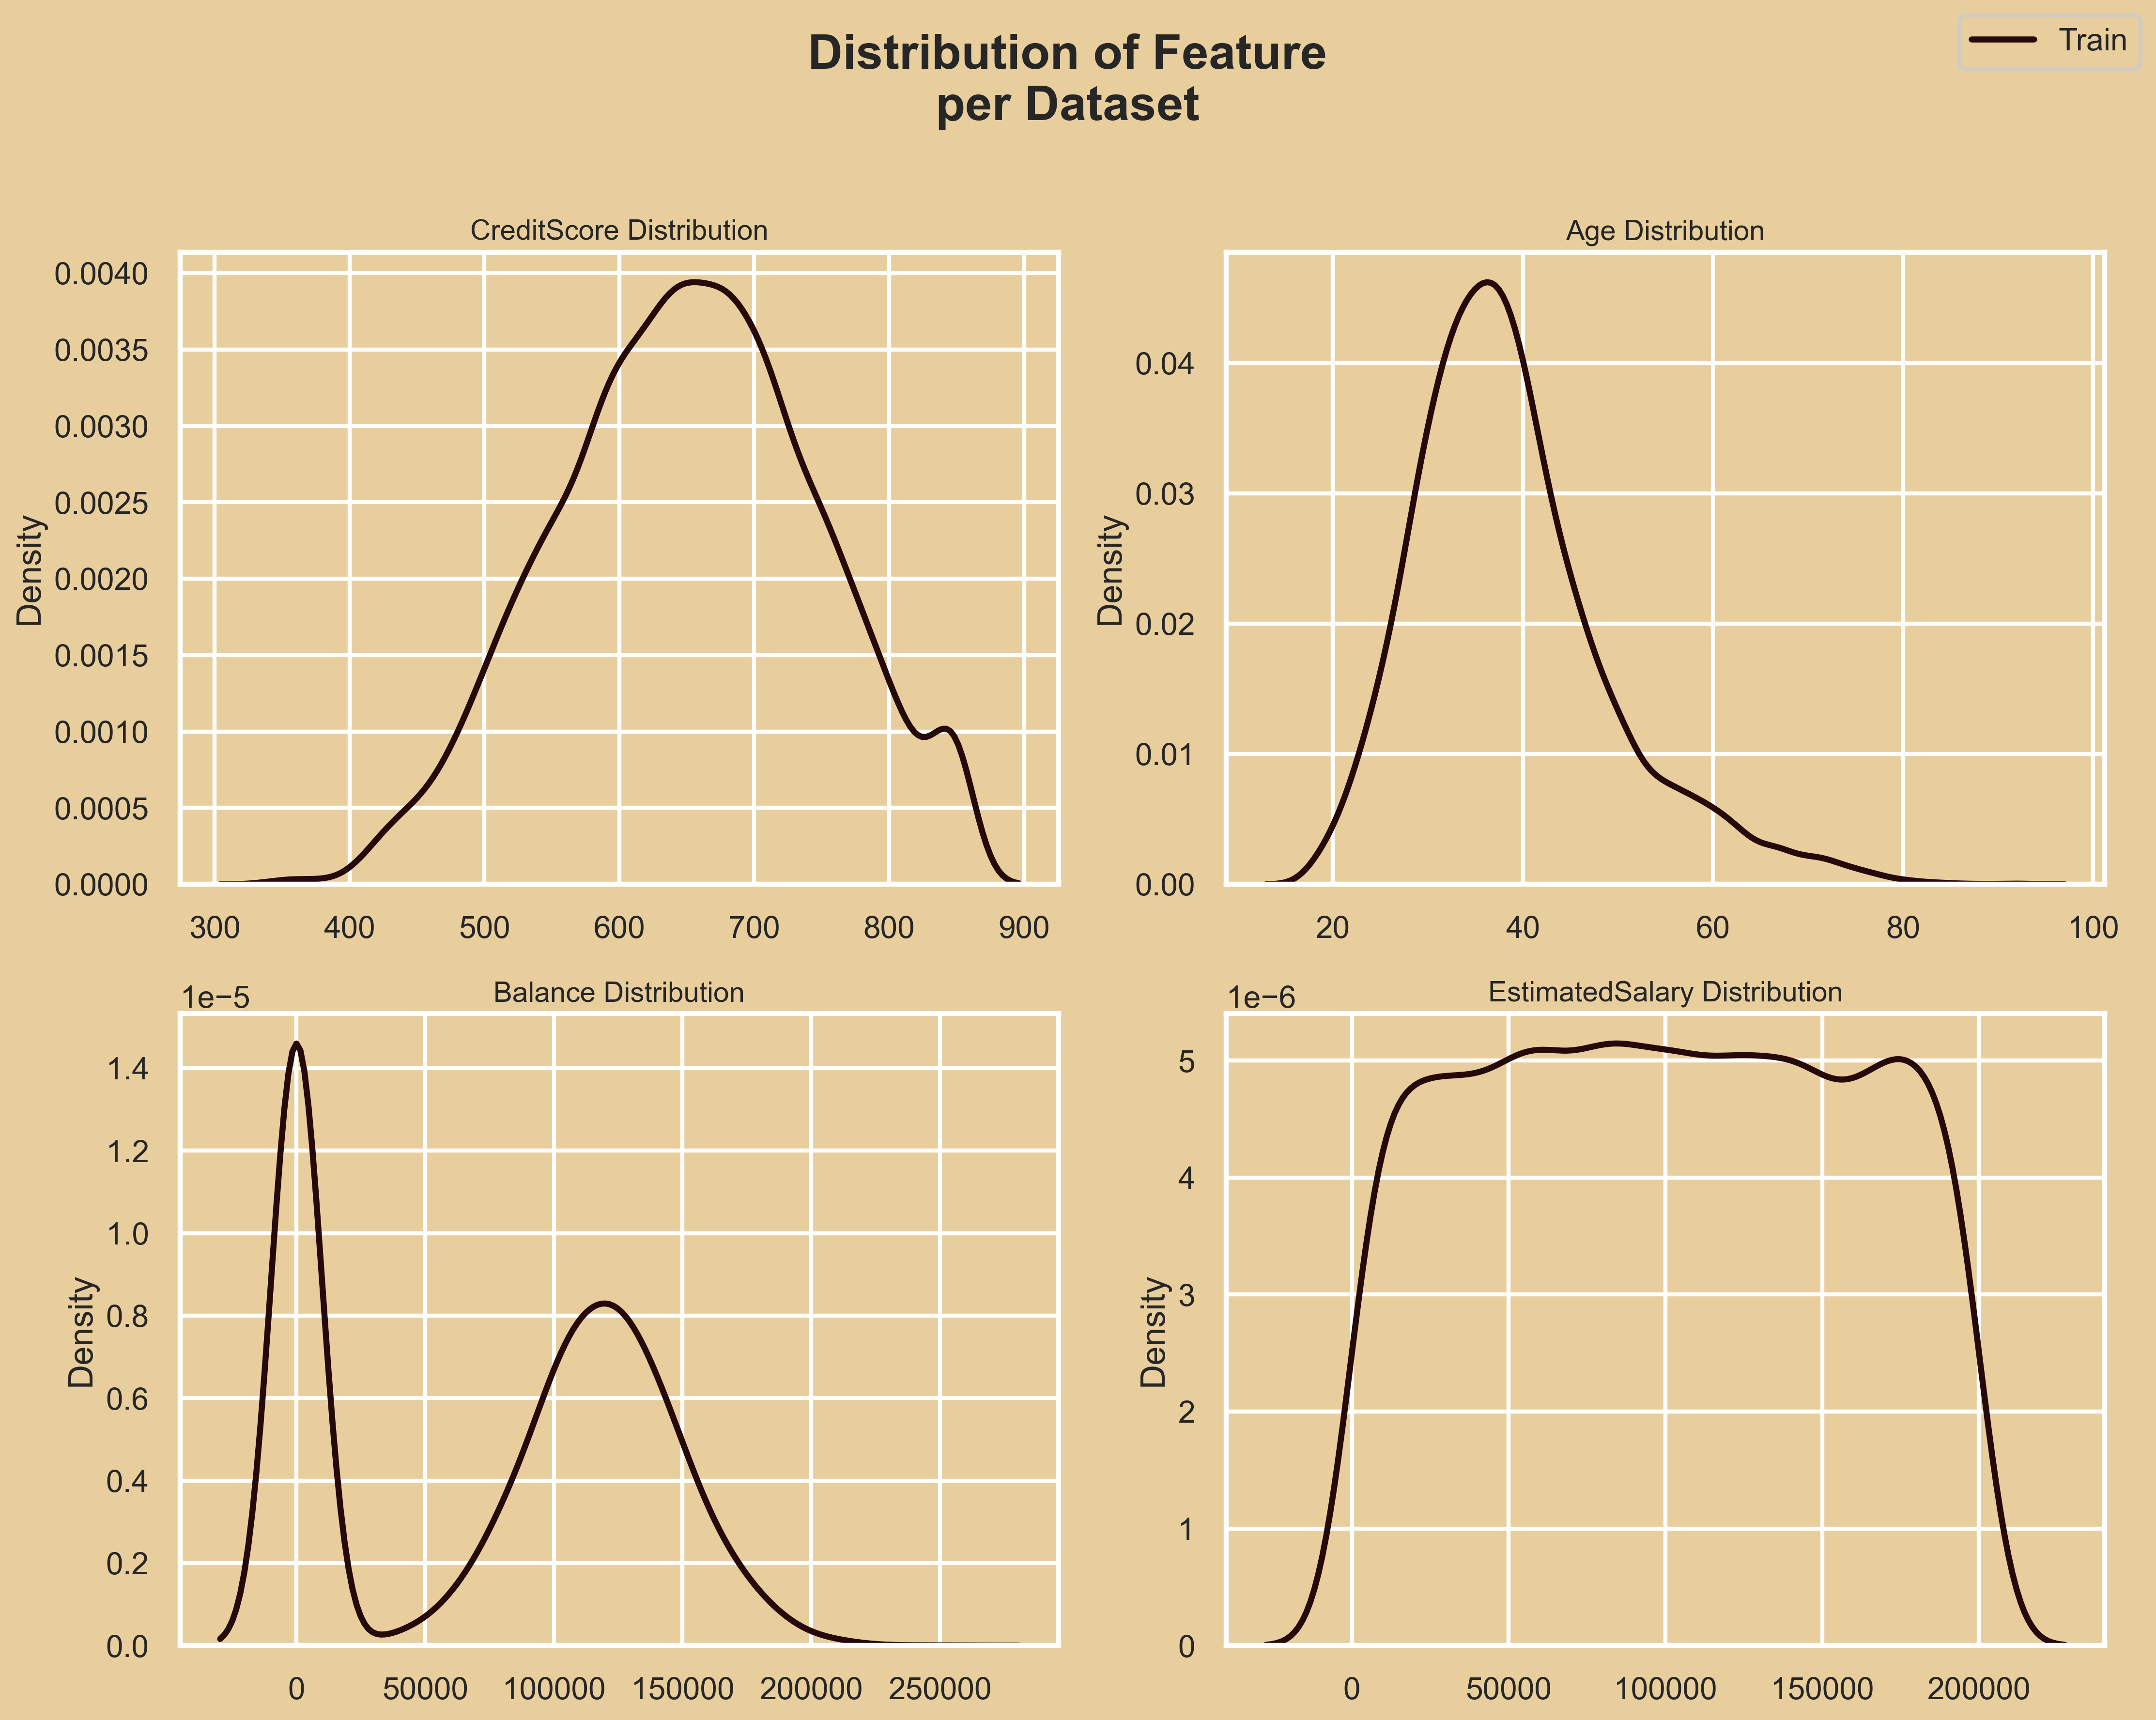

In [67]:
fig, ax = plt.subplots(2, 2, figsize = (15, 12), dpi = 300)
ax = ax.flatten()

numerical_variables = ['CreditScore','Age', 'Balance','EstimatedSalary' ]
for i, column in enumerate(numerical_variables):
    sns.kdeplot(df_train[column], ax=ax[i], palette=palette[0:2], color = '#26090b')        
    ax[i].set_title(f'{column} Distribution', size = 14)
    ax[i].set_xlabel(None)
    
fig.suptitle('Distribution of Feature\nper Dataset\n', fontsize = 24, fontweight = 'bold')
fig.legend(['Train'])
plt.tight_layout()

In [68]:
lgbParams = {'n_estimators': 1000,
             'max_depth': 25, 
             'learning_rate': 0.025,
             'min_child_weight': 3.43,
             'min_child_samples': 216, 
             'subsample': 0.782,
             'subsample_freq': 4, 
             'colsample_bytree': 0.29, 
             'num_leaves': 21}

[LightGBM] [Info] Number of positive: 5128, number of negative: 5064
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 5128, number of negative: 5064
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGB

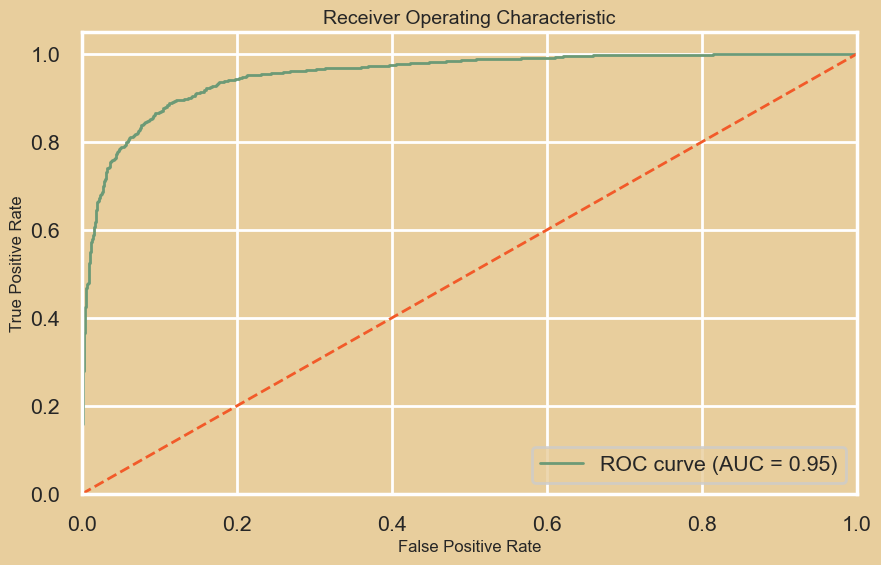

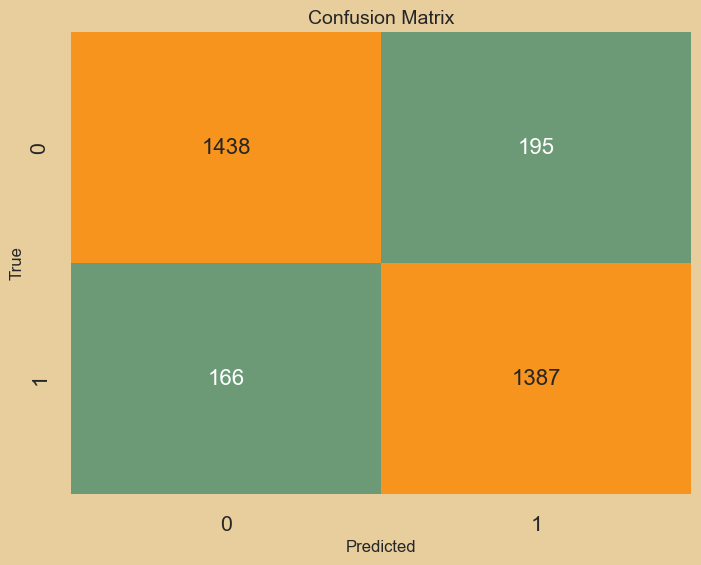


Classification Report:
              precision    recall  f1-score   support

  Not Exited       0.90      0.88      0.89      1633
      Exited       0.88      0.89      0.88      1553

    accuracy                           0.89      3186
   macro avg       0.89      0.89      0.89      3186
weighted avg       0.89      0.89      0.89      3186



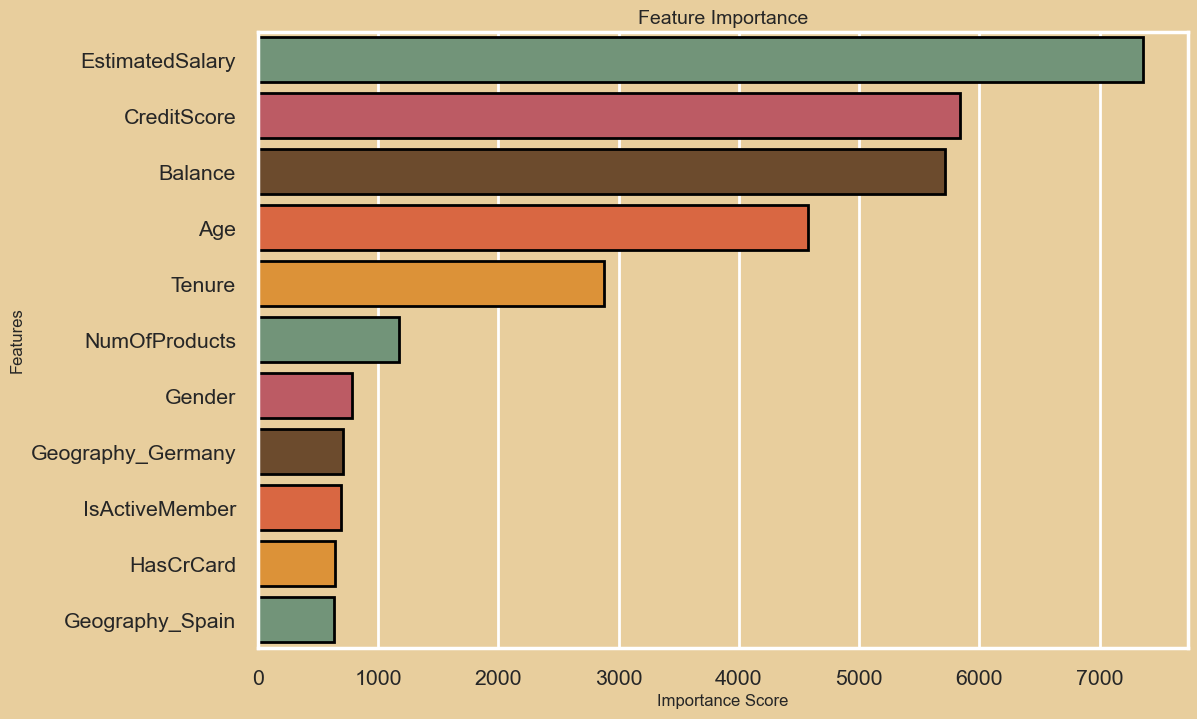

In [69]:
# 移除无关列
df = df_train.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# 处理分类变量
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])

# One-Hot编码Geography列
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

# 分离特征和目标变量
X = df.drop('Exited', axis=1)
y = df['Exited']

# 处理类别不平衡（SMOTE过采样）
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_res, test_size=0.2, random_state=42
)

# ============== 模型训练（LightGBM） ==============
lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=32,
    class_weight='balanced',
    random_state=42
)

# 交叉验证训练
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(lgb_model, X_train, y_train, cv=kfold, scoring='roc_auc')

print("Cross-Validation AUC Scores:", cv_results)
print("Mean AUC:", cv_results.mean())

# 最终训练
lgb_model.fit(X_train, y_train)

# ============== 模型评估 ==============
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# 预测概率
y_pred_prob = lgb_model.predict_proba(X_test)[:, 1]

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color=palette[2], lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color=palette[3], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic', fontsize=14)
plt.legend(loc="lower right")
plt.show()

# 混淆矩阵
y_pred = lgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=palette_cmap, 
            annot_kws={"size": 16}, cbar=False)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.show()

# 分类报告
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Exited', 'Exited']))

# ============== 特征重要性 ==============
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance, 
            palette=palette_cmap, edgecolor='black')
plt.title('Feature Importance', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()